# Part A : Predict player overall Rank

### Names of the people who worked on this Project together

**Sangani Bhavin Pravinbhai**

**Himanshu Bhardwaj**

**Lakshmanan L**

**P Ashish**



![](image/image2.jpeg)


In [1]:
#Importing the required libraries
import pandas as pd
import numpy as np
import warnings 
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate
import tensorflow as tf


warnings.simplefilter("ignore")

pd.set_option("display.max_columns",500)
pd.set_option('display.max_rows', 500)

### Reading and Viewing Data 2019 FIFA Dataset 

In [1]:
#reading the file 'players_19.csv'

fifa19 = pd.read_csv('Data/players_19.csv')
fifa19.head(3)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,31,1987-06-24,170,72,Argentina,FC Barcelona,...,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,26,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3


## Creating a function for data manipulation

In [43]:
# Creating a function for data manipulation

def data_cleaning(fdata,year):
    
    #Remove the columns which we are not going to use to train the model
    fdata=fdata.drop(columns=['sofifa_id','player_url','short_name','long_name','nationality','club','potential','real_face','team_position'
                          ,'team_jersey_number','nation_position','nation_jersey_number','player_traits','player_tags','dob'])
    
    #Selecting only one player_position for each player
    fdata['player_positions']=fdata['player_positions'].str.split(',',expand=True)[0].values
    
    # Considering only 'normal' as a body_type of all the player
    fdata['body_type'] = np.where(fdata['body_type'].isin(['Normal','Lean','Stocky']),fdata['body_type'],'Normal')
    
    # filling the missing values in 'loaned_from' column
    fdata['loaned_from'] = np.where(fdata['loaned_from'].isna,0,1)
    
    #creating a feature which represents the number of years the player has played for a club.
    fdata['club_age'] = year - pd.to_datetime(fdata['joined'],format='%Y-%m-%d').dt.year
    del fdata['joined']
    
    fdata['contract_valid_until'] = fdata['contract_valid_until'] - year
    
    # Creating the list of columns
    colname_list = ['attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes','ls', 'st', 'rs',
       'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm',
       'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb',
       'rcb', 'rb']

    # Removing the punctuation from the value of the columns in column list
    for i in range(len(colname_list)):
        if fdata[colname_list[i]].dtype=='O':
            fdata[colname_list[i]] = fdata[colname_list[i]].str.replace('+',';')
            fdata[colname_list[i]] = fdata[colname_list[i]].str.replace('-',';')
            fdata[colname_list[i]] = fdata[colname_list[i]].str.split(';',expand=True)[0].fillna(0).astype('int')
        
    #removing the duplicate columns
    fdata=fdata.drop(columns=['gk_diving', 'gk_handling', 'gk_kicking',
       'gk_reflexes', 'gk_positioning'])
    
    # filling the missing values
    for column in fdata.columns:
        if column!='gk_speed':
            fdata[column].fillna(fdata[column].mode()[0], inplace=True)
        else:
            fdata[column].fillna(0, inplace=True)
            
    #doing label encoding for the column 'player_position'
    label_encoder = LabelEncoder()
    fdata['player_positions'] = label_encoder.fit_transform(fdata['player_positions'])
    
    #Creating dummy columns
    fdata = pd.get_dummies(fdata,columns=['preferred_foot','work_rate','body_type'])
    
    # return the cleaned dataset
    return fdata

In [44]:
#Calling the function 'data_cleaning' to cleaned the dataset fifa19

fifa19=data_cleaning(fifa19,2019)

In [45]:
#Let's have a quick look of cleaned dataset

fifa19.head()

,age,height_cm,weight_kg,overall,value_eur,wage_eur,player_positions,international_reputation,weak_foot,skill_moves,release_clause_eur,loaned_from,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_speed,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,club_age,preferred_foot_Left,preferred_foot_Right,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium,body_type_Lean,body_type_Normal,body_type_Stocky
0,33,187,83,94,77000000,405000,14,5,4,5,127100000.0,0,3.0,90.0,93.0,81.0,89.0,35.0,79.0,0.0,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,1.0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
1,31,170,72,94,110500000,565000,3,5,4,4,226500000.0,0,2.0,88.0,91.0,88.0,96.0,32.0,61.0,0.0,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88,88,88,92,93,93,93,92,93,93,93,90,84,84,84,90,63,61,61,61,63,58,47,47,47,58,15.0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
2,26,175,68,92,118500000,290000,8,5,5,5,228100000.0,0,3.0,92.0,84.0,83.0,95.0,32.0,59.0,0.0,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,2.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
3,27,193,76,91,72000000,260000,5,4,3,1,138600000.0,0,0.0,67.0,59.0,62.0,65.0,63.0,70.0,58.0,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
4,27,181,70,91,102000000,355000,0,4,5,4,196400000.0,0,4.0,77.0,86.0,92.0,87.0,60.0,78.0,0.0,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,4.0,0,1,1,0,0,0,0,0,0,0,0,0,1,0


### Feature scalling

In [46]:
# Excluding the encoded columns
scaling_cols=fifa19.iloc[:,:81].columns.tolist()
scaling_cols.remove('overall')

In [47]:
#Standardizing the data
scaler=StandardScaler()
scaler.fit(fifa19[scaling_cols])
fifa19[scaling_cols]=scaler.transform(fifa19[scaling_cols])

In [48]:
#let's Have quick look of scaled dataset
fifa19.head()

,age,height_cm,weight_kg,overall,value_eur,wage_eur,player_positions,international_reputation,weak_foot,skill_moves,release_clause_eur,loaned_from,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_speed,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,club_age,preferred_foot_Left,preferred_foot_Right,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium,body_type_Lean,body_type_Normal,body_type_Stocky
0,1.678067,0.851907,1.086057,94,13.208903,17.691161,1.716611,9.679567,1.597936,3.539521,11.380296,0.0,1.451130,2.085705,2.985570,2.313866,2.675078,-1.133877,1.444738,-0.341059,1.867226,2.477479,2.108801,1.516148,2.493652,1.728274,1.844465,1.896188,1.585511,2.134989,1.640415,1.796007,1.593214,3.766708,0.429387,2.295884,2.515566,1.559242,1.08422,2.383727,0.418954,-0.848328,2.308108,2.024470,2.313072,3.190384,-0.963355,-0.763851,-1.057610,-0.545508,-0.322328,-0.080558,-0.144626,-0.321924,1.971062,1.971062,1.971062,1.761868,1.832882,1.832882,1.832882,1.761868,1.721030,1.721030,1.721030,1.689862,1.459454,1.459454,1.459454,1.689862,0.701038,0.524072,0.524072,0.524072,0.701038,0.531303,0.177586,0.177586,0.177586,0.531303,-0.695389,0,1,0,1,0,0,0,0,0,0,0,0,1,0
1,1.248129,-1.668217,-0.467656,94,19.143758,24.856406,-0.672365,9.679567,1.597936,2.205566,20.595321,0.0,0.680761,1.898443,2.836279,3.006990,3.383644,-1.323570,-0.486506,-0.341059,1.486806,2.528563,1.018325,2.125870,2.437135,2.203514,2.497005,2.926332,2.235554,2.254550,1.774243,1.455829,1.863906,3.656454,2.193872,1.716032,0.244117,0.557209,-0.50318,2.435575,-0.443093,-1.185930,2.256965,2.870594,1.677365,3.278092,-0.712385,-0.901972,-0.917119,-0.601622,-0.322328,-0.080558,-0.144626,-0.487870,1.822161,1.822161,1.822161,1.906105,1.977855,1.977855,1.977855,1.906105,1.962111,1.962111,1.962111,1.786319,1.608485,1.608485,1.608485,1.786319,0.600962,0.524072,0.524072,0.524072,0.600962,0.381410,-0.112198,-0.112198,-0.112198,0.381410,6.009730,1,0,0,0,0,0,0,0,0,0,1,0,1,0
2,0.173282,-0.927004,-1.032643,92,20.561036,12.541142,0.413533,9.679567,3.114618,3.539521,20.743651,0.0,1.451130,2.272967,2.313762,2.511902,3.282420,-1.323570,-0.701089,-0.341059,1.595497,2.119892,0.559178,1.719388,2.324102,2.150709,2.225113,2.525720,1.650515,2.194770,1.974985,1.727971,2.202270,3.546200,1.417498,1.426106,-0.344777,1.120853,-1.29688,1.813404,0.016665,-0.510725,2.001253,2.377022,2.058789,3.102675,-1.013549,-1.086132,-0.589306,-0.433279,-0.439776,-0.080558,-0.086291,-0.321924,1.623625,1.623625,1.623625,1.761868,1.784558,1.784558,1.784558,1.761868,1.769246,1.769246,1.769246,1.689862,1.459454,1.459454,1.459454,1.689862,0.701038,0.474720,0.474720,0.474720,0.701038,0.481339,-0.112198,-0.112198,-0.112198,0.481339,-0.216452,0,1,0,0,1,0,0,0,0,0,0,0,1,0
3,0.388251,1.741362,0.097331,91,12.323104,11.197658,-0.238005,7.186258,0.081254,-1.796297,12.446421,0.0,-0.859979,-0.067807,0.447628,0.432530,0.245711,0.636596,0.479116,4.235372,-1.773936,-1.660311,-1.793954,-0.584008,-1.688600,-1.968031,-1.418238,-1.365934,-0.104599,-0.973594,-0.500835,-0.449164,-0.233953,3.105184,-1.476258,-1.415169,0.159989,-1.258978,-0.10633,-1.815925,-1.017791,-0.800099,-1.936716,1.037327,-0.547610,0.822257,

In [49]:
# creating predictors and response variable
X=fifa19.drop(columns=['overall'])
y=fifa19['overall']


In [50]:
# Splitting the dataset into train set and validation set
X_train,X_val,y_train,y_val=train_test_split(X,y,train_size=0.8,random_state=42)

## Linear Regression

In [51]:
# Multi-linear Regression
lreg=LinearRegression()
lreg.fit(X_train,y_train)
y_val_pred=lreg.predict(X_val)
lreg_val_mse=mean_squared_error(y_val,y_val_pred)
print(f'The MSE of linear regression model on validation set is {lreg_val_mse}')

The MSE of linear regression model on validation set is 5.950260805631697


## Lasso Regression

In [52]:
# finding the best alpha value
alpha_list=[1e-7,1e-5,1e-3,1e-1,1e1,1e2]
val_mse_list=[]
train_mse_list=[]
for alpha in alpha_list:
    lasso=Lasso(alpha=alpha)
    cross_val=cross_validate(lasso,X_train,y_train,cv=5,scoring='neg_mean_squared_error',return_train_score=True)
    val_mse=-np.mean(cross_val['test_score'])
    train_mse=-np.mean(cross_val['train_score'])
    val_mse_list.append(val_mse)
    train_mse_list.append(train_mse)

In [53]:
best_alpha=alpha_list[val_mse_list.index(min(val_mse_list))]
print(f'The best alpha value is {best_alpha}')

The best alpha value is 1e-07


In [54]:
# now build a model using best alpha value
lasso=Lasso(alpha=best_alpha)
lasso.fit(X_train,y_train)
val_pred=lasso.predict(X_val)
val_mse=mean_squared_error(y_val,val_pred)
print(f'The val MSE of the lasso model is {val_mse}')

The val MSE of the lasso model is 6.031487474752707


In [55]:
# Finding the significant features using bootstrapping.

features=X_train.columns.tolist()

#number of bootstrap
num_bootstrap=25

# creating the 
beta_dict={col:0 for col in features}

for i in range(num_bootstrap):
    df_new = fifa19.sample(frac=1, replace=True)
    x=df_new.drop(columns=['overall'])
    y=df_new['overall']
    lasso=Lasso(alpha=best_alpha)
    lasso.fit(x,y)
    for i in range(len(features)):
        if abs(lasso.coef_[i])>0.1:
            beta_dict[features[i]]+=1
    

In [56]:
# Here we have considered only those features whose beta value is grater than 0.1 in atleast 15 bootstrap out of 25. 

#creating a list to store the significant features
sign_features=[]

for i in range(len(features)):
    if beta_dict[features[i]]>=15:
        sign_features.append(features[i])

In [57]:
# now using the only significant features to train the model
lasso_2=Lasso(alpha=best_alpha)
lasso_2.fit(X_train[sign_features],y_train)
val_pred_2=lasso_2.predict(X_val[sign_features])
val_mse_2=mean_squared_error(y_val,val_pred_2)

print(f'The val MSE of the lasso model with only significant features is {val_mse_2}')

The val MSE of the lasso model with only significant features is 6.025088542224083


## Neural Network 

In [58]:
# Creating a Model
tf.random.set_seed(42)
model=tf.keras.Sequential([
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(1,activation='relu')
])

# Compiling the model
model.compile(loss='mse',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['mse'])

#Early Stopping Callback
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

#Number of epochs
epoch=30

#Fitting the model
history=model.fit(X_train[sign_features],
         y_train,
         epochs=epoch,
         validation_split=0.25,
         callbacks=[callback],
         verbose=1
         )

Epoch 1/30
334/334 [==============================] - 13s 28ms/step - loss: 1582.5131 - mse: 1582.5131 - val_loss: 81.2859 - val_mse: 81.2859
Epoch 2/30
334/334 [==============================] - 8s 25ms/step - loss: 51.6264 - mse: 51.6264 - val_loss: 36.9475 - val_mse: 36.9475
Epoch 3/30
334/334 [==============================] - 9s 26ms/step - loss: 27.1273 - mse: 27.1273 - val_loss: 22.3921 - val_mse: 22.3921
Epoch 4/30
334/334 [==============================] - 8s 24ms/step - loss: 17.9603 - mse: 17.9603 - val_loss: 16.0616 - val_mse: 16.0616
Epoch 5/30
334/334 [==============================] - 8s 25ms/step - loss: 13.3928 - mse: 13.3928 - val_loss: 11.8518 - val_mse: 11.8518
Epoch 6/30
334/334 [==============================] - 8s 24ms/step - loss: 10.2529 - mse: 10.2529 - val_loss: 9.0301 - val_mse: 9.0301
Epoch 7/30
334/334 [==============================] - 8s 25ms/step - loss: 7.9472 - mse: 7.9472 - val_loss: 6.8526 - val_mse: 6.8526
Epoch 8/30
334/334 [======================

In [59]:
val_mse=model.evaluate(X_val[sign_features],y_val)[1]


112/112 [==============================] - 8s 2ms/step - loss: 0.9185 - mse: 0.9185


In [60]:
print(f'The validation MSE of the neural network model is {val_mse}')

The validation MSE of the neural network model is 0.9184733033180237


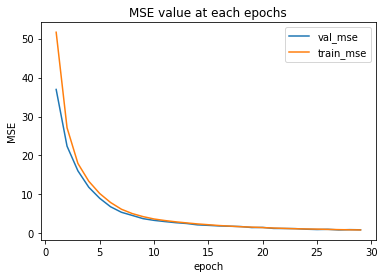

In [61]:
# Visualizing the learning of the model
plt.plot(range(1,len(history.history['val_mse'][1:])+1),history.history['val_mse'][1:],label='val_mse')
plt.plot(range(1,len(history.history['mse'][1:])+1),history.history['mse'][1:],label='train_mse')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.title('MSE value at each epochs')
plt.legend()

**Since the neural network is giving the good results,we will use it to predict the overall skill of the players in fifa20 edition**

## Predicting on dataset FIFA20

**Test Set** : Players from the following clubs

1) FC Barcelona  2) FC Bayern München 3) Real Madrid 4) Paris Saint-Germain 5) Juventus 6) Manchester City 7) Liverpool FC

In [2]:
# Reading the file 'players_20.csv'

fifa20=pd.read_csv('Data/players_20.csv')

In [63]:
#list of clubs going to be used for test set 
clubs=['FC Barcelona','FC Bayern München','Real Madrid','Paris Saint-Germain','Juventus','Manchester City','Liverpool FC']

In [64]:
#have considerd only players from the clubs which has been given in the instruction
fifa20=fifa20[fifa20['club'].isin(clubs) ]

In [65]:
#Let's have a quick look of the dataset fifa20
fifa20.head(3)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,"Beat Offside Trap, Argues with Officials, Earl...",88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,"Long Throw-in, Selfish, Argues with Officials,...",84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Injury Free, Selfish, Early C...",87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3


In [66]:
# storing the name of the player to use it later on

name_df=fifa20[['short_name','long_name']]
overall_ranking=fifa20['overall']

In [67]:
# Cleaning the dataset fifa20

fifa20=data_cleaning(fifa20,2020)

In [68]:
# Scaling the features.

fifa20[scaling_cols]=scaler.transform(fifa20[scaling_cols])

after conidering only those players which are from given clubs,we are left with no player having work_rate as low so eventually
we are getting one less column than the columns we have used to train the model so we have added one column'work_rate_Low/Low'
with all entries as 0.

In [69]:
#adding a column 'work_rate_Low/Low' with all entries as 0
fifa20['work_rate_Low/Low']=np.zeros(shape=(len(fifa20),1))

In [70]:
# Let's have a quick look of the dataset

fifa20.head()

,age,height_cm,weight_kg,overall,value_eur,wage_eur,player_positions,international_reputation,weak_foot,skill_moves,release_clause_eur,loaned_from,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_speed,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,club_age,preferred_foot_Left,preferred_foot_Right,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium,body_type_Lean,body_type_Normal,body_type_Stocky,work_rate_Low/Low
0,1.463098,-1.668217,-0.467656,94,16.486360,24.856406,1.065072,9.679567,1.597936,2.205566,17.749232,0.0,-0.089609,1.804812,2.910925,3.403061,3.383644,-0.880952,0.049951,-0.341059,2.084608,2.528563,1.018325,2.261364,2.550169,2.203514,2.497005,2.926332,2.560575,2.254550,1.774243,1.319758,1.999251,3.656454,2.193872,1.774018,0.244117,0.745090,0.21115,2.435575,-0.443093,-0.317809,2.256965,2.870594,1.677365,3.278092,-0.712385,-0.487611,-0.917119,-0.601622,-0.322328,-0.080558,-0.144626,-0.487870,1.871795,1.871795,1.871795,1.954184,1.977855,1.977855,1.977855,1.954184,1.962111,1.962111,1.962111,1.882777,1.757515,1.757515,1.757515,1.882777,0.851152,0.770829,0.770829,0.770829,0.851152,0.631232,0.129289,0.129289,0.129289,0.631232,6.488667,1,0,0,0,0,0,0,0,1,0,0,1,0,0.0
1,1.893037,0.851907,1.086057,93,9.931446,17.691161,1.282252,9.679567,1.597936,3.539521,8.543478,0.0,0.680761,2.085705,2.985570,2.412884,2.675078,-1.133877,1.337446,-0.341059,1.867226,2.477479,2.108801,1.651641,2.493652,1.781079,1.844465,1.896188,1.585511,2.015428,1.640415,1.796007,1.593214,3.766708,0.499966,2.295884,2.515566,1.371361,1.00485,2.383727,0.418954,-0.848328,2.308108,2.024470,2.313072,3.190384,-0.963355,-0.717811,-1.010779,-0.545508,-0.322328,-0.080558,-0.144626,-0.321924,1.971062,1.971062,1.971062,1.761868,1.832882,1.832882,1.832882,1.761868,1.721030,1.721030,1.721030,1.689862,1.459454,1.459454,1.459454,1.689862,0.701038,0.524072,0.524072,0.524072,0.701038,0.531303,0.177586,0.177586,0.177586,0.531303,-0.216452,0,1,0,1,0,0,0,0,0,0,0,1,0,0.0
2,0.388251,-0.927004,-1.032643,92,18.257958,12.541142,0.413533,9.679567,3.114618,3.539521,17.693608,0.0,0.680761,2.179336,2.388407,2.907972,3.282420,-1.323570,-0.808380,-0.341059,2.030263,2.119892,0.559178,1.922629,2.493652,2.150709,2.225113,2.525720,1.845528,2.194770,1.974985,1.659936,2.202270,3.325692,1.417498,1.426106,-0.344777,1.120853,-1.29688,1.917099,-0.270684,-0.510725,1.898968,2.588553,2.630926,3.102675,-1.013549,-0.994052,-0.776628,-0.433279,-0.439776,-0.080558,-0.086291,-0.321924,1.623625,1.623625,1.623625,1.809947,1.784558,1.784558,1.784558,1.809947,1.817462,1.817462,1.817462,1.738090,1.509131,1.509131,1.509131,1.738090,0.751076,0.524072,0.524072,0.524072,0.751076,0.531303,-0.160496,-0.160496,-0.160496,0.531303,0.262486,0,1,0,0,1,0,0,0,0,0,0,1,0,0.0
4,0.603221,-0.927004,-0.185163,91,15.511981,20.602042,0.413533,7.186258,1.597936,2.205566,16.701648,0.0,2.221500,2.179336,2.239117,2.808955,3.181197,-1.133877,0.049951,-0.341059,1.704189,1.966641,0.501784,2.058123,2.267585,2.097905,1.953221,2.067879,1.975537,2.134989,1.974985,1.591900,2.134597,3.105184,2.123293,1.542077,-0.765416,1.308734,-0.18570,1.709709,-0.098274,-0.269580,1.898968,2.518042,2.503784,2.839550,-0.662191,-0.948012

In [71]:
#  Predicting the Overall (OVR ) skill Statistic for players in the FIFA 20 Edition

pred=model.predict(fifa20[sign_features])

## Finding the test MSE

In [72]:
# now let's find the final mse on test set(players from the clubs mentioned above)

mse_fifa20=model.evaluate(fifa20[sign_features],fifa20['overall'])[1]

6/6 [==============================] - 7s 3ms/step - loss: 1.4724 - mse: 1.4724


In [73]:
print(f'The final test mse of the model(neural network) is {mse_fifa20} ')

The final test mse of the model(neural network) is 1.4724414348602295 


**Test MSE = 1.26**    (the Result might be changed because of the randomness in the neural network )

## Finding the best players

In [80]:
# creating a prediction dataset in which the 'overall' will be our predicted overall ranking of the player
fifa20_pred=fifa20.copy()
fifa20_pred['pred_overall']=np.round(pred)
fifa20_pred['short_name']=name_df['short_name']
fifa20_pred['long_name']=name_df['long_name']
fifa20['short_name']=name_df['short_name']
fifa20['long_name']=name_df['long_name']

In [82]:
# Sorting the prediction dataset based on the overall ranking of the player to find out the best player

fifa20_pred.sort_values(by='pred_overall',ascending=False,inplace=True)

**Top five players**

In [97]:
#finding the top five players based on the 'overall' predicted by our model
top_five_players=fifa20_pred.loc[:5,['short_name','pred_overall']]
top_five_players['actual_overall']=fifa20[fifa20['short_name'].isin(top_five_players['short_name'].values)]['overall']


In [98]:
#have a look of top five players
top_five_players

,short_name,pred_overall,actual_overall
0,L. Messi,94.0,94
1,Cristiano Ronaldo,92.0,93
2,Neymar Jr,91.0,92
4,E. Hazard,91.0,91
5,K. De Bruyne,91.0,91


**Best player**

In [83]:
# finding the best players from overall ranking
best_player=fifa20_pred.iloc[0,:]['short_name']
best_overall=fifa20_pred.iloc[0,:]['pred_overall']

print(f"The player having the highest overall ranking is '{best_player}' with overall ranking {best_overall}")


The player having the highest overall ranking is 'L. Messi' with overall ranking 94.0


**According to our analysis, the current best player in the world is 'L.Messi'**

**Note**:again,the Result might be changed because of the randomness in the neural network

## Best player in the world

![](image/image1.jpeg)

**Name**  : Lionel Messi

**Nationality** : Argentina

**Club**   :  Paris Saint-Germain